# Activity recognition on the Capture24 dataset

## Neural networks for feature engineering

*This section assumes familiarity with [PyTorch](https://pytorch.org/)*

In this section, instead of using the hand-crafted features, we use a neural network on the raw accelerometer measurements so that we let the neural network automatically learn relevant features for classification.

###### Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
# from tqdm import tqdm
from tqdm.notebook import tqdm
import utils

# For reproducibility
np.random.seed(42)
torch.manual_seed(42)
cudnn.benchmark = True

 ###### Grab a GPU if there is one 

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using {} device: {}".format(device, torch.cuda.current_device()))
else:
    device = torch.device("cpu")
    print("Using {}".format(device))

Using cuda device: 0


 ###### Load dataset and hold out some instances for testing 

In [3]:
data = np.load('capture24.npz', allow_pickle=True)
# data = np.load('capture24_small.npz', allow_pickle=True)
print("Contents of capture24.npz:", data.files)
y, pid, time = data['y'], data['pid'], data['time']
X = np.load('X_raw.npy', mmap_mode='r')
# X = np.load('X_raw_small.npy')
print("Raw dataset shape:", X.shape)

# Hold out some participants for testing the model
pids_test = [2, 3]
mask_test = np.isin(pid, pids_test)
mask_train = ~mask_test
y_train, y_test = y[mask_train], y[mask_test]
pid_train, pid_test = pid[mask_train], pid[mask_test]
# X[mask_train] and X[mask_test] if you like to live dangerously
X_train = utils.ArrayFromMask(X, mask_train)
X_test = utils.ArrayFromMask(X, mask_test)
print("Shape of X_train", X_train.shape)
print("Shape of X_test", X_test.shape)

Contents of capture24.npz: ['X_feats', 'y', 'pid', 'time', 'annotation']
Raw dataset shape: (330610, 3, 3000)
Shape of X_train (325619, 3, 3000)
Shape of X_test (4991, 3, 3000)


###### Architecture design

As a baseline model, we use a convolutional neural network (CNN) with a typical pyramid-like structure. The input to the network is a `(N,3,3000)` array, corresponding to `N` instances of raw triaxial measurements of activity. The output of the network is a `(N,5)` array representing predicted *class scores* for each instance.
To obtain probabilities, we can pass each row to a softmax. Then to report a class label, we can pick the highest probability in each row. We output class scores instead of class probabilities or labels because the loss function that we will use operates on the scores (see further below).

In [4]:
class ConvBNReLU(nn.Module):
    ''' Convolution + batch normalization + ReLU is a common trio '''
    def __init__(
        self, in_channels, out_channels,
        kernel_size=3, stride=1, padding=1, bias=True
    ):
        super(ConvBNReLU, self).__init__()

        self.main = nn.Sequential(
            nn.Conv1d(in_channels, out_channels,
                kernel_size, stride, padding, bias=bias),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(True)
        )

    def forward(self, x):
        return self.main(x)


class CNN(nn.Module):
    ''' Typical CNN design with pyramid-like structure '''
    def __init__(self, output_size=5, in_channels=3, num_filters_init=8):
        super(CNN, self).__init__()

        self.cnn = nn.Sequential(
            ConvBNReLU(in_channels, num_filters_init,
            8, 4, 2, bias=False),  # 750
            ConvBNReLU(num_filters_init, num_filters_init*2,
            6, 4, 2, bias=False),  # 188
            ConvBNReLU(num_filters_init*2, num_filters_init*4,
            8, 4, 2, bias=False),  # 47
            ConvBNReLU(num_filters_init*4, num_filters_init*8,
            3, 2, 1, bias=False),  # 24
            ConvBNReLU(num_filters_init*8, num_filters_init*16,
            4, 2, 1, bias=False),  # 12
            ConvBNReLU(num_filters_init*16, num_filters_init*32,
            4, 2, 1, bias=False),  # 6
            ConvBNReLU(num_filters_init*32, num_filters_init*64,
            6, 1, 0, bias=False),  # 1
            nn.Conv1d(num_filters_init*64, output_size,
            1, 1, 0, bias=True)
        )

    def forward(self, x):
        return self.cnn(x).view(x.shape[0],-1)

###### Helper functions

We need a few helper functions:
- A data loader that will provide the mini-batches during training.
- A helper function that forward-passes the model on a dataset by chunks &mdash; this is simply to prevent the memory from blowing up.
- A function to train a Hidden Markov Model (HMM) using the probabilistic predictions of the model for smoothing.
- A function that evaluates the model (CNN + HMM) on a dataset, to be used to track the performance during training.

In [5]:
def create_dataloader(X, y=None, batch_size=1, shuffle=False):
    ''' Create a (batch) iterator over the dataset. Alternatively, use PyTorch's
    Dataset and DataLoader classes -- See
    https://pytorch.org/tutorials/beginner/data_loading_tutorial.html '''
    if shuffle:
        idxs = np.random.permutation(np.arange(len(X)))
    else:
        idxs = np.arange(len(X))
    for i in range(0, len(idxs), batch_size):
        idxs_batch = idxs[i:i+batch_size]
        X_batch = X[idxs_batch]
        X_batch = torch.from_numpy(X_batch)
        if y is None:
            yield X_batch
        else:
            y_batch = y[idxs_batch]
            y_batch = torch.from_numpy(y_batch)
            yield X_batch, y_batch

def forward_by_batches(cnn, X):
    ''' Forward pass model on a dataset. Do this by batches so that we do
    not blow up the memory. '''
    Y = []
    cnn.eval()
    with torch.no_grad():
        for x in create_dataloader(X, batch_size=1024, shuffle=False):  # do not shuffle here!
            x = x.to(device)
            Y.append(cnn(x))
    cnn.train()
    Y = torch.cat(Y)
    return Y

def train_hmm(cnn, X, y):
    ''' Use the probabilistic predictions of the CNN to compute the Hidden
    Markov Model parameters '''
    Y_pred = forward_by_batches(cnn, X)  # scores
    Y_pred = F.softmax(Y_pred, dim=1)  # probabilities
    Y_pred = Y_pred.cpu().numpy()  # cast to numpy array
    prior, emission, transition = utils.train_hmm(Y_pred, y)
    return prior, emission, transition

def evaluate_model(cnn, prior, emission, transition, X, y, pid=None):
    Y_pred = forward_by_batches(cnn, X)  # scores
    loss = F.cross_entropy(Y_pred, torch.from_numpy(y).to(device)).item()
    Y_pred = F.softmax(Y_pred, dim=1)  # convert to probabilities
    y_pred = torch.argmax(Y_pred, dim=1)  # convert to classes
    y_pred = y_pred.cpu().numpy()  # cast to numpy array
    y_pred = utils.viterbi(y_pred, prior, emission, transition)  # HMM smoothing
    kappa = utils.cohen_kappa_score(y, y_pred, pid)
    accuracy = utils.accuracy_score(y, y_pred, pid)
    return loss, kappa, accuracy

###### Hyperparameters, model instantiation, loss function and optimizer

Now we set the hyperparameters, instantiate the model, define the loss
function (we use cross entropy for multiclass classification) and optimizer
(we use AMSGRAD &mdash; a variant of SGD).

In [6]:
num_filters_init = 8  # initial num of filters -- see class definition
in_channels = 3  # num channels of the signal -- equal to 3 for our raw triaxial timeseries
output_size = utils.NUM_CLASSES  # number of classes (sleep, sedentary, etc...)
num_epoch = 10  # num epochs (full loops though the training set) for SGD training
lr = 1e-3  # learning rate in SGD
batch_size = 32  # size of the mini-batch in SGD

cnn = CNN(
    output_size=output_size,
    in_channels=in_channels,
    num_filters_init=num_filters_init
).to(device)
print(cnn)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=lr, amsgrad=True)

CNN(
  (cnn): Sequential(
    (0): ConvBNReLU(
      (main): Sequential(
        (0): Conv1d(3, 8, kernel_size=(8,), stride=(4,), padding=(2,), bias=False)
        (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (1): ConvBNReLU(
      (main): Sequential(
        (0): Conv1d(8, 16, kernel_size=(6,), stride=(4,), padding=(2,), bias=False)
        (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (2): ConvBNReLU(
      (main): Sequential(
        (0): Conv1d(16, 32, kernel_size=(8,), stride=(4,), padding=(2,), bias=False)
        (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (3): ConvBNReLU(
      (main): Sequential(
        (0): Conv1d(32, 64, kernel_size=(3,), stride=(2,), padding=(1,), bias=False)
        (1): BatchNorm1d(64, eps=

###### Training

Training via mini-batch gradient descent begins here. We loop through the training set `num_epoch` times with the `dataloader` iterator.

In [7]:
loss_history = []
kappa_history = []
accuracy_history = []
loss_history_train = []
for i in tqdm(range(num_epoch)):
    dataloader = create_dataloader(X_train, y_train, batch_size, shuffle=True)
    losses = []
    for x, target in dataloader:
        x, target = x.to(device), target.to(device)
        cnn.zero_grad()
        output = cnn(x)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()

        # Logging -- track train loss
        losses.append(loss.item())

    # -------------------------------------------------------------------------
    # Evaluate performance at the end of each epoch (full loop through the
    # training set). We could also do this at every iteration, but this would
    # be very expensive since we are evaluating on the entire dataset.
    # Aditionally, at the end of each epoch we train a Hidden Markov Model to
    # smooth the predictions of the CNN.
    # -------------------------------------------------------------------------

    # Logging -- average train loss in this epoch
    loss_history_train.append(np.mean(losses))

    # Compute HMM params
    prior, emission, transition = train_hmm(cnn, X_train, y_train)

    # Logging -- evalutate performance on test set
    loss_test, kappa_test, accuracy_test = evaluate_model(
        cnn, prior, emission, transition, X_test, y_test, pid_test
    )
    loss_history.append(loss_test)
    kappa_history.append(kappa_test)
    accuracy_history.append(accuracy_test)

 ###### Plot score and loss history 

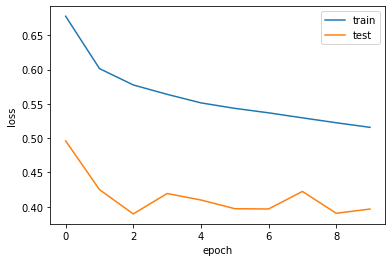

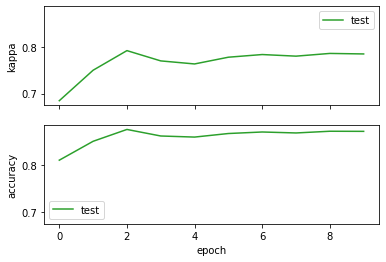

In [8]:
# Loss history
fig, ax = plt.subplots()
ax.plot(loss_history_train, color='C0', label='train')
ax.plot(loss_history, color='C1', label='test')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend()
fig.show()

# Kappa and accuracy history
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True)
ax1.plot(kappa_history, color='C2', label='test')
ax1.set_ylabel('kappa')
ax1.legend()
ax2.plot(accuracy_history, color='C2', label='test')
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')
ax2.legend()
fig.show()

###### Ideas
- Implement early stopping to select the model at its best out-of-sample performance. Do we track kappa or accuracy?
- Helping the model to learn:
    - As an attempt to remove gravity, try detrending the signal. You can implement this in the dataloader:

        ```python
        # Do this before torch.from_numpy()
        X_batch = scipy.signal.detrend(X_batch, type='constant')
        ```

        See [scipy.signal.detrend](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.detrend.html). More generally, consider removing the low frequencies of the signal, e.g. 0 - 0.5Hz.

    - Add a 4th channel containing the vector magnitude, i.e. $(x,y,z,r)$ where $r = \sqrt{x^2+y^2+z^2}$. You can implement this in the dataloader:

        ```python
        # Do this before torch.from_numpy()
        X_batch = np.concatenate((X_batch, np.linalg.norm(X_batch, axis=1, keepdims=True)), axis=1)
        ```

    - Consider using [spherical coordinates](https://en.wikipedia.org/wiki/Spherical_coordinate_system), or adding them as additional channels.

- Modify the architecture. Feel free to use recent architectures such as ResNet.

###### References

- [A recipe for training neural networks](http://karpathy.github.io/2019/04/25/recipe/)
- [PyTorch's Conv1d module](https://pytorch.org/docs/stable/nn.html#conv1d)